## 1. Data reading

#### 1.1 First read the raw datasets

In [1]:
import numpy as np
import pandas as pd

raw_data_feature = pd.read_csv("C:\\Users\\haoji\\COMP4434\\fma_metadata\\fma_metadata\\features.csv", low_memory=False)
raw_data_genre = pd.read_csv("C:\\Users\\haoji\\COMP4434\\fma_metadata\\fma_metadata\\genres.csv", low_memory=False)
raw_data_echonest = pd.read_csv("C:\\Users\\haoji\\COMP4434\\fma_metadata\\fma_metadata\\raw_echonest.csv", low_memory=False)
raw_data_track = pd.read_csv("C:\\Users\\haoji\\COMP4434\\fma_metadata\\fma_metadata\\raw_tracks.csv", low_memory=False)

In [2]:
print("The shape of dataset feature: ")
print(raw_data_feature.shape)
print("The shape of dataset genre: ")
print(raw_data_genre.shape)
print("The shape of dataset echonest: ")
print(raw_data_echonest.shape)
print("The shape of dataset track: ")
print(raw_data_track.shape)

The shape of dataset feature: 
(106577, 519)
The shape of dataset genre: 
(163, 5)
The shape of dataset echonest: 
(14514, 250)
The shape of dataset track: 
(109727, 39)


#### 1.2 Merge the datasets

First select the body of the data

In [3]:
data_feature = raw_data_feature[3:]
data_echonest = raw_data_echonest[3:]
data_track = raw_data_track[:]
data_genre = raw_data_genre[:]

Then, rename some column's name of the dataset.

In [4]:
data_feature = data_feature.rename(columns={'feature':"trackid"})
echonest_column = ['trackid'] + list(raw_data_echonest.iloc[1])[1:]
for i in range(0,len(echonest_column)):
    if echonest_column[i].isnumeric():
        echonest_column[i] = "echonest" + echonest_column[i]
data_echonest.columns = echonest_column
data_track = data_track.rename(columns={'track_id':"trackid"})
data_echonest['trackid'] = data_echonest['trackid'].apply(pd.to_numeric)
data_feature['trackid'] = data_feature['trackid'].apply(pd.to_numeric)

C:\Users\haoji\AppData\Local\Temp\ipykernel_24364\3478274060.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_echonest['trackid'] = data_echonest['trackid'].apply(pd.to_numeric)


Merge the dataset

In [5]:
init_dataset = pd.merge(data_feature, data_echonest, how='inner', on=['trackid'])
init_dataset = pd.merge(init_dataset, data_track, how='inner', on=['trackid'])
init_dataset.shape

(13554, 806)

Drop features that have no practical meaning(URL of license's image file, artist website, ...) and features mostly consist of empty data.

In [6]:
dropped = ["artist_location", "tags", "artist_url", "artist_website", 
           "license_image_file_large", "track_url", "license_url", 
           "license_title", "license_image_file", "track_file", 
           "track_explicit", "artist_name_x", "album_title",
           "track_date_recorded", "track_date_created", "track_lyricist", 
           "track_information", "track_copyright_c","track_copyright_p",
           "artist_name_y", "track_explicit_notes", "track_composer", 
           "track_publisher", "album_url", "release","album_name",
           "album_date", "album_id", "track_image_file", "track_language_code"]

dataset_after_drop = init_dataset.drop(dropped, axis = 1)
dataset_after_drop.shape

(13554, 776)

Set the data type of "artist location", "track_language_code" to 'category'.

In [7]:
category_list = []
dataset_after_drop[category_list] = dataset_after_drop[category_list].astype("category")

#### 1.3 Processing string features

In [8]:
numericList = ["acousticness","danceability","energy","instrumentalness","liveness","speechiness","tempo","valence","artist_latitude", 
"artist_longitude", "artist_discovery_rank", "artist_familiarity_rank", "artist_hotttnesss_rank","song_currency_rank",
"song_hotttnesss_rank","artist_discovery", "artist_familiarity", "artist_hotttnesss", "song_currency",  "song_hotttnesss"]

for i in dataset_after_drop:
    if i[:6] == "chroma" or i[:4] == "mfcc" or i[:4] == "rmse" or i[:8] == "spectral" or i[:7] == "tonnetz" or i[:3] == "zcr" or i[:8] == "echonest" or i in numericList:
        dataset_after_drop[i] = dataset_after_drop[i].apply(pd.to_numeric)
    for j in dataset_after_drop[i]:
        if type(j) == type("string"):
            print(i)
            print(j)
            break

track_duration
02:48
track_genres
[{'genre_id': '21', 'genre_title': 'Hip-Hop', 'genre_url': 'http://freemusicarchive.org/genre/Hip-Hop/'}]
track_title
Food


Convert "track_duration" to seconds.

In [9]:
dataset_after_phase = dataset_after_drop.copy()
for i in range(0, len(dataset_after_drop["track_duration"])):
    tmp = 0
    lis = []
    for j in dataset_after_drop["track_duration"][i]:
        if j == ":":
            lis.append(tmp)
            tmp = 0
        else:
            tmp = tmp * 10 + int(j)
    res = 0
    for j in lis:
        res = res * 60 + j
    res = res * 60 + tmp
    dataset_after_phase["track_duration"].iloc[i] = res
    #print(dataset_after_phase["track_duration"][i])
dataset_after_phase.shape

C:\Users\haoji\AppData\Local\Temp\ipykernel_24364\1277584647.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_after_phase["track_duration"].iloc[i] = res


(13554, 776)

Use word2vec to analyze the track title, first set up the sentences.

In [10]:
from gensim.models import Word2Vec

sentences = []
for title in dataset_after_phase['track_title']:
    if type(title) == type("string"):
        sentences.append(title.split())
    else:
        sentences.append(str(title))


Train the word2vec model to get the vector of song's title

In [11]:
model = Word2Vec(sentences, hs=1, workers=1, min_count=1, window=5)
#model.accuracy("C:\\Users\\duan2\\OneDrive\\code\\py\\COMP4434\\questions-words.txt")
#model.save("C:\\Users\\duan2\\OneDrive\\code\\py\\COMP4434\\mymodel")

Calculate the title's vector

In [12]:
from gensim.models import KeyedVectors
wv = model.wv
dic = {}
for i in range(1, len(wv['Food']) + 1):
    Str = "Vector" + str(i) 
    dic[Str] = []
for title in dataset_after_phase['track_title']:
    if type(title) == type("string"):
        tmp = wv[title.split()]
        tmp = np.average(tmp, axis=0)
        for i in range(1, len(tmp) + 1):
            Str = "Vector" + str(i) 
            dic[Str].append(tmp[i - 1])
    else:
        if wv.__contains__(str(title)):
            tmp = wv[str(title)]
            for i in range(1, len(tmp) + 1):
                Str = "Vector" + str(i) 
                dic[Str].append(tmp[i - 1])
        else:
            for i in range(1, len(tmp) + 1):
                Str = "Vector" + str(i) 
                dic[Str].append(None)



Merge the vector dataset and the original dataset.

In [13]:
from pandas import Series,DataFrame
dic['trackid'] = dataset_after_phase['trackid']
dataset_vector = DataFrame(dic)
dataset_after_word2vec = pd.merge(dataset_vector, dataset_after_phase, how='inner', on=['trackid'])
dataset_after_word2vec = dataset_after_word2vec.drop('track_title',axis = 1)
dataset_after_word2vec = dataset_after_word2vec.infer_objects()
dataset_after_word2vec.shape

(13554, 875)

Get the genre column.

In [14]:
dataset_after_dropna = dataset_after_word2vec.dropna(subset=['track_genres'], inplace=False)
Genre = dataset_after_dropna['track_genres']
dataset_after_dropna = dataset_after_dropna.drop('track_genres', axis = 1)
dataset_after_dropna.shape


(13554, 874)

## 2. Data preprocessing

#### 2.1 fill empty values and normalization

In [15]:
from sklearn.preprocessing import MinMaxScaler
dataset_after_dropna.fillna(dataset_after_dropna.mean(), inplace=True)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(dataset_after_dropna)


#### Processing label data

In [16]:
import ast

lis = []
for i in range(0, len(Genre)):
    lis.append(ast.literal_eval(Genre[i])[0]['genre_id'])
Genre_df = DataFrame({"genre_id" : lis})
Y = pd.get_dummies(Genre_df['genre_id'], prefix='genre')
#print("Y.shape: " + str(Y.shape))


dic_genre = {}
for j in Y.columns:
    dic_genre[j] = []
for i in range(0, len(Genre)):
    lis = []
    for j in ast.literal_eval(Genre[i]):
        lis.append("genre_" + str(j['genre_id']))
    for j in Y.columns:
        if j in lis: dic_genre[j].append(1)
        else: dic_genre[j].append(0)

Y1 = DataFrame(dic_genre)

dic_genre = {}
for j in Y.columns:
    dic_genre[j] = []

name_map = {}
for i in range(0, len(Genre)):
    lis = []
    for j in ast.literal_eval(Genre[i]):
        lis.append("genre_" + str(j['genre_id']))
        name_map["genre_" + str(j['genre_id'])] = str(j['genre_title'])

    for j in Y.columns:
        if j in lis: dic_genre[j].append(1)
        else: dic_genre[j].append(0)

            
name_map["genre_1235"] = "Instrumental"
Y1 = DataFrame(dic_genre)
        



In [17]:
X_before_PCA = pd.DataFrame(X_scaled)        
indices_to_drop = []
for index, row in Y1.iterrows():
    flag = 0
    for j in row[:]:
        if j == 1:
            flag += 1
    if flag >= 2:
        indices_to_drop.append(index)

Y1.drop(indices_to_drop, axis=0, inplace=True)
X_before_PCA.drop(indices_to_drop, axis=0, inplace=True)

print(Y1.shape)
print(type(Y1))
print(X_before_PCA.shape)
print(type(X_before_PCA))


(10192, 23)
<class 'pandas.core.frame.DataFrame'>
(10192, 874)
<class 'pandas.core.frame.DataFrame'>


In [18]:
dic_count = {}
for column_name, row in Y1.items():
    dic_count[name_map[column_name]] = row.tolist().count(1)
print(dic_count)


#map "genre_num" to genre name
Y2_rename_columns = Y1.rename(columns=name_map)
Y2_rename_columns['Rock'] = Y2_rename_columns['Rock'] + Y2_rename_columns['Post-Rock'] + Y2_rename_columns['Punk'] + Y2_rename_columns['Metal'] + Y2_rename_columns['Post-Punk'] + Y2_rename_columns['Indie-Rock'] + Y2_rename_columns['Psych-Rock']
Y2_rename_columns['Electronic'] = Y2_rename_columns['Electronic'] + Y2_rename_columns['Chiptune'] + Y2_rename_columns['Trip-Hop'] 
Y2_rename_columns['Folk'] = Y2_rename_columns['Folk'] + Y2_rename_columns['Psych-Folk']
Y2_rename_columns['Instrumental'] = Y2_rename_columns['Soundtrack'] + Y2_rename_columns['Compilation']
Y2_rename_columns['Experimental'] = Y2_rename_columns['Kid-Friendly']+ Y2_rename_columns['Sound Art']
Y2_rename_columns['Other'] = Y2_rename_columns['Experimental']+ Y2_rename_columns['Instrumental']+ Y2_rename_columns['Blues']+ Y2_rename_columns['International']


# drop sub-classes
dropped = ["Post-Rock", "Post-Punk", "Punk", "Metal", "Indie-Rock", "Psych-Rock", "Compilation", 
           "Chiptune", "Trip-Hop", "Psych-Folk", "Soundtrack", "Kid-Friendly", "Sound Art","Experimental","Instrumental","Blues","International"]
Y2_after_dropped = Y2_rename_columns.drop(dropped, axis = 1)

print(Y2_after_dropped)


{'Pop': 533, 'Rock': 1524, 'Electronic': 2099, 'Folk': 837, 'Soundtrack': 156, 'International': 176, 'Hip-Hop': 987, 'Chiptune': 244, 'Punk': 704, 'Post-Rock': 64, 'Trip-Hop': 171, 'Blues': 88, 'Metal': 168, 'Psych-Folk': 199, 'Kid-Friendly': 12, 'Jazz': 403, 'Classical': 354, 'Sound Art': 6, 'Compilation': 4, 'Psych-Rock': 365, 'Indie-Rock': 461, 'Old-Time / Historic': 430, 'Post-Punk': 207}
       Pop  Rock  Electronic  Folk  Hip-Hop  Jazz  Classical  \
0        0     0           0     0        1     0          0   
1        0     0           0     0        1     0          0   
2        0     0           0     0        1     0          0   
3        1     0           0     0        0     0          0   
4        0     0           0     0        1     0          0   
...    ...   ...         ...   ...      ...   ...        ...   
13548    0     0           1     0        0     0          0   
13549    0     0           1     0        0     0          0   
13550    0     0           1

#### Do feature selection using Chi-square before PCA

In [149]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
X = X_before_PCA.to_numpy()
Y = Y2_after_dropped.to_numpy()
# Remove column 290 from X, because it is all 1s
X_new = np.concatenate((X[:,:290], X[:,291:]), axis=1)
print(X_new.shape)
selector = SelectKBest(chi2)
X_selected = selector.fit_transform(X_new, Y)
# Get the chi-square scores for all features (excluding feature 290)
chi2_scores = chi2(X_new, Y)[0]
# Sort features based on chi-square score
sorted_chi2 = sorted(list(enumerate(chi2_scores)), key=lambda x: x[1], reverse=True)
# Select features with chi-square score > 2 and store them in an array called X_ready_for_PCA
selected_features = []
for idx, score in sorted_chi2:
    if score > 2:
        selected_features.append(idx)
X_ready_for_PCA = X_new[:, selected_features]
print(X_ready_for_PCA.shape)

(10192, 873)
(10192, 744)


#### Use PCA to do the feature reduction

First, calculate how many dimension we need by calcuing the Cumulative Variance Contribution.

We choose to keep variance above 90%.

In [150]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_ready_for_PCA)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance_ratio >= 0.9) + 1
print(num_components)

pca = PCA(n_components = num_components)
X_pca = pca.fit_transform(X_ready_for_PCA)

print(X_pca.shape)
print(X_pca)
X_FinalArray = X_pca


121
(10192, 121)
[[-7.53410453e-01 -4.29467610e-01 -2.44826551e-01 ...  4.80966570e-02
   6.05622990e-02  7.52250266e-02]
 [-1.14180189e+00 -5.57406288e-01  3.48839340e-03 ...  6.09803216e-02
   6.84933768e-02 -1.09942971e-01]
 [-4.32039045e-01  6.84607697e-01  1.18279287e+00 ... -7.16813172e-02
   3.23940091e-04 -2.16371488e-02]
 ...
 [-1.58078420e+00  1.23319353e+00  1.40536140e+00 ... -9.31769079e-04
   8.73688886e-02 -1.12642033e-02]
 [-1.85389324e+00  1.40306002e+00  1.13352744e+00 ... -2.37081809e-01
   3.76155859e-03 -1.27762265e-02]
 [ 6.78142402e-01  1.05029564e+00  1.48447678e+00 ... -5.50507332e-02
  -5.58931642e-03  8.35754613e-04]]


Applying the PCA

genre_id to genre title

In [151]:
dic_count = {}
for column_name, row in Y1.items():
    dic_count[name_map[column_name]] = row.tolist().count(1)
print(dic_count)


#map "genre_num" to genre name
Y2_rename_columns = Y1.rename(columns=name_map)
Y2_rename_columns['Rock'] = Y2_rename_columns['Rock'] + Y2_rename_columns['Post-Rock'] + Y2_rename_columns['Punk'] + Y2_rename_columns['Metal'] + Y2_rename_columns['Post-Punk'] + Y2_rename_columns['Indie-Rock'] + Y2_rename_columns['Psych-Rock']
Y2_rename_columns['Electronic'] = Y2_rename_columns['Electronic'] + Y2_rename_columns['Chiptune'] + Y2_rename_columns['Trip-Hop'] 
Y2_rename_columns['Folk'] = Y2_rename_columns['Folk'] + Y2_rename_columns['Psych-Folk']
Y2_rename_columns['Instrumental'] = Y2_rename_columns['Soundtrack'] + Y2_rename_columns['Compilation']
Y2_rename_columns['Experimental'] = Y2_rename_columns['Kid-Friendly']+ Y2_rename_columns['Sound Art']
Y2_rename_columns['Other'] = Y2_rename_columns['Experimental']+ Y2_rename_columns['Instrumental']+ Y2_rename_columns['Blues']+ Y2_rename_columns['International']


# drop sub-classes
dropped = ["Post-Rock", "Post-Punk", "Punk", "Metal", "Indie-Rock", "Psych-Rock", "Compilation", 
           "Chiptune", "Trip-Hop", "Psych-Folk", "Soundtrack", "Kid-Friendly", "Sound Art","Experimental","Instrumental","Blues","International"]
Y2_after_dropped = Y2_rename_columns.drop(dropped, axis = 1)


Y2_sum = Y2_after_dropped.sum()
Y2_sum = Y2_sum.sort_values( ascending=False)
print(Y2_sum)



{'Pop': 533, 'Rock': 1524, 'Electronic': 2099, 'Folk': 837, 'Soundtrack': 156, 'International': 176, 'Hip-Hop': 987, 'Chiptune': 244, 'Punk': 704, 'Post-Rock': 64, 'Trip-Hop': 171, 'Blues': 88, 'Metal': 168, 'Psych-Folk': 199, 'Kid-Friendly': 12, 'Jazz': 403, 'Classical': 354, 'Sound Art': 6, 'Compilation': 4, 'Psych-Rock': 365, 'Indie-Rock': 461, 'Old-Time / Historic': 430, 'Post-Punk': 207}
Rock                   3493
Electronic             2514
Folk                   1036
Hip-Hop                 987
Pop                     533
Other                   442
Old-Time / Historic     430
Jazz                    403
Classical               354
dtype: int64


In [152]:
Y2_after_dropped_array = Y2_after_dropped.values
print(Y2_after_dropped_array.shape)
np.save('Y2_after_dropped_array.npy', Y2_after_dropped_array)
np.save('X_FinalArray.npy',X_FinalArray)

(10192, 9)


## 3.Model training

In [1]:
import numpy as np
Y2_after_dropped_array = np.load('Y2_after_dropped_array.npy')
X_FinalArray = np.load('X_FinalArray.npy')
print(X_FinalArray.shape)
print(Y2_after_dropped_array.shape)

(10192, 121)
(10192, 9)


#### 3.1 split data into training and testing set, define 5 fold cross validation

In [22]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split

X_train_all, X_evaluation, y_train_all, y_evaluation = train_test_split(X_FinalArray, Y2_after_dropped_array, test_size=0.25, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)



In [23]:
y_train_all = np.argmax(y_train_all, axis=1)
y_evaluation = np.argmax(y_evaluation, axis=1)
print(y_train_all.shape)
print(y_train_all)
print(y_evaluation.shape)

class_counts1 = np.bincount(y_train_all)
print(class_counts1)

class_counts = np.bincount(y_evaluation)
print(class_counts)



(7644,)
[1 3 2 ... 4 1 3]
(2548,)
[ 405 2583 1894  785  742  314  269  318  334]
[128 910 620 251 245  89  85 112 108]


####

#### 3.1 SVM 

In [157]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer
import time

SVM = SVC()

# Define the scoring function as micro f1
scorer = make_scorer(f1_score, average='macro')

# Define the hyperparameters to tune
grid_search_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Set up the GridSearchCV object with the scorer
grid_search_svm = GridSearchCV(
    estimator=SVM,
    param_grid=grid_search_params,
    cv=kf,
    n_jobs=-1,
    scoring=scorer
)

# Fit the grid search to the training data
grid_search_svm.fit(X_train_all, y_train_all)

# Print out the performance for each combination of hyperparameters
cv_results = grid_search_svm.cv_results_
for i in range(len(cv_results['params'])):
    print("Hyperparameters: ", cv_results['params'][i])
    print("Mean cross-validation score (macro f1): ", cv_results['mean_test_score'][i])

print("-----------------------------------------------------------------------------------------")
print("Best hyperparameters: ", grid_search_svm.best_params_)
print("Best performance in 5-fold cross validation (macro f1): ", grid_search_svm.best_score_)





Hyperparameters:  {'C': 0.1, 'kernel': 'linear'}
Mean cross-validation score (macro f1):  0.6036994453583988
Hyperparameters:  {'C': 0.1, 'kernel': 'poly'}
Mean cross-validation score (macro f1):  0.36368495295496805
Hyperparameters:  {'C': 0.1, 'kernel': 'rbf'}
Mean cross-validation score (macro f1):  0.45756772447520044
Hyperparameters:  {'C': 0.1, 'kernel': 'sigmoid'}
Mean cross-validation score (macro f1):  0.45779583106451066
Hyperparameters:  {'C': 1, 'kernel': 'linear'}
Mean cross-validation score (macro f1):  0.6394094774869735
Hyperparameters:  {'C': 1, 'kernel': 'poly'}
Mean cross-validation score (macro f1):  0.5838703536200239
Hyperparameters:  {'C': 1, 'kernel': 'rbf'}
Mean cross-validation score (macro f1):  0.6559864950945296
Hyperparameters:  {'C': 1, 'kernel': 'sigmoid'}
Mean cross-validation score (macro f1):  0.5015692636771256
Hyperparameters:  {'C': 10, 'kernel': 'linear'}
Mean cross-validation score (macro f1):  0.6354135776033457
Hyperparameters:  {'C': 10, 'kern

Training time:  5.780102491378784
Testing time:  2.2242579460144043
Test score (macro f1):  0.7451519007046881
Accuracy: 0.7755102040816326
Precision: 0.7847908051539453
Recall: 0.7179549328309413
F1-score: 0.7451519007046881
Confusion matrix:
[[ 46  37  29  12   4   0   0   0   0]
 [ 21 788  47  34   7   3   0   1   9]
 [  8  62 500  16  21   4   1   0   8]
 [  7  48  16 172   1   2   0   0   5]
 [  1  17  56   3 168   0   0   0   0]
 [  3  22   8   4   0  50   0   0   2]
 [  0   0   2   3   0   0  80   0   0]
 [  0   0   0   1   0   0   0 111   0]
 [  5  21  14   3   0   2   2   0  61]]


Text(50.722222222222214, 0.5, 'True label')

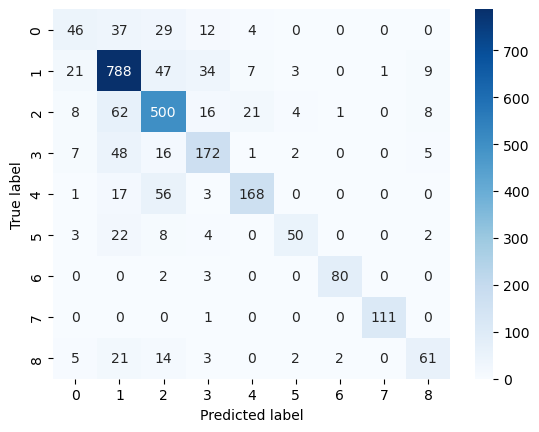

In [159]:
# Create the final classifier with the best hyperparameters
final_svm = SVC(**grid_search_svm.best_params_)
start_time = time.time()
final_svm.fit(X_train_all, y_train_all)
end_time = time.time()
training_time = end_time - start_time
print("Training time: ", training_time)

# Evaluate the final classifier on the test set
start_time = time.time()
y_pred = final_svm.predict(X_evaluation)
end_time = time.time()
testing_time = end_time - start_time
print("Testing time: ", testing_time)

test_score = f1_score(y_evaluation, y_pred, average='macro')
print("Test score (macro f1): ", test_score)


print("Accuracy:", accuracy_score(y_evaluation, y_pred))
print("Precision:", precision_score(y_evaluation, y_pred, average='macro'))
print("Recall:", recall_score(y_evaluation, y_pred, average='macro'))
print("F1-score:", f1_score(y_evaluation, y_pred, average='macro'))
print("Confusion matrix:")
print(confusion_matrix(y_evaluation, y_pred))




from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_evaluation, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')


#### 3.2 Logistic Regression

In [160]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
import time

LR = LogisticRegression(max_iter=100000000)

# Define the scoring function as macro f1
scorer = make_scorer(f1_score, average='macro')

# Define the hyperparameters to tune
grid_search_params = {
    'C': [0.1, 1, 10,50],
    'solver': ['saga', 'sag'],
    'multi_class': ['ovr', 'multinomial']
}

# Set up the GridSearchCV object with the scorer
grid_search_lr = GridSearchCV(
    estimator=LR,
    param_grid=grid_search_params,
    cv=kf,
    n_jobs=-1,
    scoring=scorer
)

# Fit the grid search to the training data
grid_search_lr.fit(X_train_all, y_train_all)

# Print out the performance for each combination of hyperparameters
cv_results = grid_search_lr.cv_results_
for i in range(len(cv_results['params'])):
    print("Hyperparameters: ", cv_results['params'][i])
    print("Mean cross-validation score (macro f1): ", cv_results['mean_test_score'][i])

print("-----------------------------------------------------------------------------------------")
print("Best hyperparameters: ", grid_search_lr.best_params_)
print("Best performance in 5-fold cross validation (macro f1): ", grid_search_lr.best_score_)






Hyperparameters:  {'C': 0.1, 'multi_class': 'ovr', 'solver': 'saga'}
Mean cross-validation score (macro f1):  0.5573989697632264
Hyperparameters:  {'C': 0.1, 'multi_class': 'ovr', 'solver': 'sag'}
Mean cross-validation score (macro f1):  0.5573989697632264
Hyperparameters:  {'C': 0.1, 'multi_class': 'multinomial', 'solver': 'saga'}
Mean cross-validation score (macro f1):  0.5798290880846863
Hyperparameters:  {'C': 0.1, 'multi_class': 'multinomial', 'solver': 'sag'}
Mean cross-validation score (macro f1):  0.5798290880846863
Hyperparameters:  {'C': 1, 'multi_class': 'ovr', 'solver': 'saga'}
Mean cross-validation score (macro f1):  0.6179940233029388
Hyperparameters:  {'C': 1, 'multi_class': 'ovr', 'solver': 'sag'}
Mean cross-validation score (macro f1):  0.6177223138322564
Hyperparameters:  {'C': 1, 'multi_class': 'multinomial', 'solver': 'saga'}
Mean cross-validation score (macro f1):  0.6331059093215099
Hyperparameters:  {'C': 1, 'multi_class': 'multinomial', 'solver': 'sag'}
Mean cro

Training time:  7.472567319869995
Testing time:  0.0014917850494384766
Test score (macro f1):  0.6299773083368936
Accuracy: 0.7182103610675039
Precision: 0.663170745342919
Recall: 0.6203751085373937
F1-score: 0.6299773083368936
Confusion matrix:


Text(50.722222222222214, 0.5, 'True label')

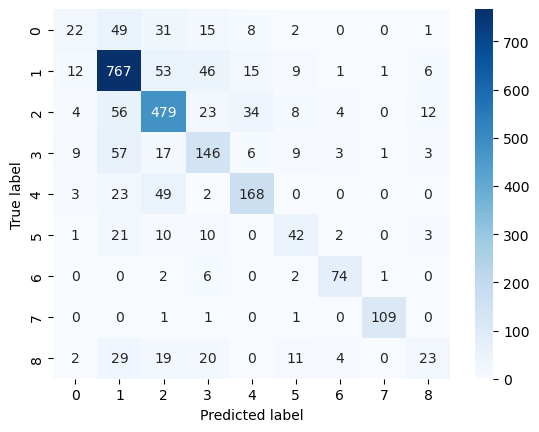

In [161]:
# Create the final classifier with the best hyperparameters
final_lr = LogisticRegression(**grid_search_lr.best_params_,max_iter=100000000)
start_time = time.time()
final_lr.fit(X_train_all, y_train_all)
end_time = time.time()
training_time = end_time - start_time
print("Training time: ", training_time)

# Evaluate the final classifier on the test set
start_time = time.time()
y_pred = final_lr.predict(X_evaluation)
end_time = time.time()
testing_time = end_time - start_time
print("Testing time: ", testing_time)

test_score = f1_score(y_evaluation, y_pred, average='macro')
print("Test score (macro f1): ", test_score)

print("Accuracy:", accuracy_score(y_evaluation, y_pred))
print("Precision:", precision_score(y_evaluation, y_pred, average='macro'))
print("Recall:", recall_score(y_evaluation, y_pred, average='macro'))
print("F1-score:", f1_score(y_evaluation, y_pred, average='macro'))
print("Confusion matrix:")
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_evaluation, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')


#### 3.3 Random Forest

In [162]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
import time

# Create a Random Forest classifier object
RF = RandomForestClassifier()

# Define the scoring function as macro f1
scorer = make_scorer(f1_score, average='macro')

# Define the hyperparameters to tune
grid_search_params = {
    'n_estimators': [200,500],
    'max_depth': [10, 20],
    'max_features': ['sqrt','log2'],
}

# Set up the GridSearchCV object with the scorer
grid_search_rf = GridSearchCV(
    estimator=RF,
    param_grid=grid_search_params,
    cv=kf,
    n_jobs=-1,
    scoring=scorer
)

# Fit the grid search to the training data
grid_search_rf.fit(X_train_all, y_train_all)

# Print out the performance for each combination of hyperparameters
cv_results = grid_search_rf.cv_results_
for i in range(len(cv_results['params'])):
    print("Hyperparameters: ", cv_results['params'][i])
    print("Mean cross-validation score (macro f1): ", cv_results['mean_test_score'][i])

print("-----------------------------------------------------------------------------------------")
print("Best hyperparameters: ", grid_search_rf.best_params_)
print("Best performance in 5-fold cross validation (macro f1): ", grid_search_rf.best_score_)


Hyperparameters:  {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Mean cross-validation score (macro f1):  0.43087765291863456
Hyperparameters:  {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}
Mean cross-validation score (macro f1):  0.4331841544070921
Hyperparameters:  {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}
Mean cross-validation score (macro f1):  0.3497731296324221
Hyperparameters:  {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 500}
Mean cross-validation score (macro f1):  0.3509074959735617
Hyperparameters:  {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 200}
Mean cross-validation score (macro f1):  0.476486599562587
Hyperparameters:  {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 500}
Mean cross-validation score (macro f1):  0.47920879604569055
Hyperparameters:  {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 200}
Mean cross-validation score (macro f1):  0.44404057266585034
Hyperparame

Training time:  67.09172797203064
Testing time:  0.4688410758972168
Test score (macro f1):  0.49291491991396746
Accuracy: 0.6632653061224489
Precision: 0.7393721647829659
Recall: 0.4718892482711824
F1-score: 0.49291491991396746
Confusion matrix:


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(50.722222222222214, 0.5, 'True label')

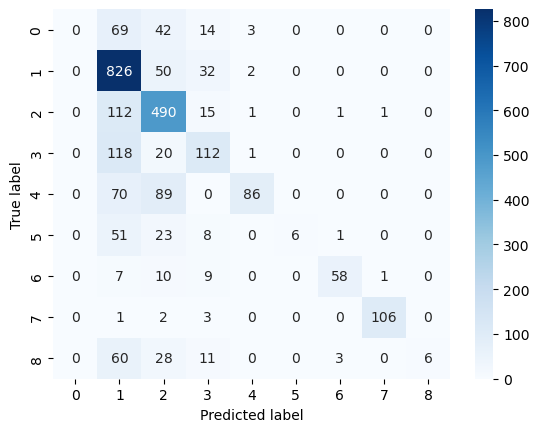

In [163]:
from sklearn.ensemble import RandomForestClassifier

# Create the final classifier with the best hyperparameters
final_rf = RandomForestClassifier(**grid_search_rf.best_params_)
start_time = time.time()
final_rf.fit(X_train_all, y_train_all)
end_time = time.time()
training_time = end_time - start_time
print("Training time: ", training_time)

# Evaluate the final classifier on the test set
start_time = time.time()
y_pred = final_rf.predict(X_evaluation)
end_time = time.time()
testing_time = end_time - start_time
print("Testing time: ", testing_time)

test_score = f1_score(y_evaluation, y_pred, average='macro')
print("Test score (macro f1): ", test_score)

print("Accuracy:", accuracy_score(y_evaluation, y_pred))
print("Precision:", precision_score(y_evaluation, y_pred, average='macro'))
print("Recall:", recall_score(y_evaluation, y_pred, average='macro'))
print("F1-score:", f1_score(y_evaluation, y_pred, average='macro'))
print("Confusion matrix:")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_evaluation, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')






#### 3.4 Naiive Bayes

In [179]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
import time

# Create a Naive Bayes classifier object
NB = MultinomialNB()

scaler = MinMaxScaler()
X_train_all_positive = scaler.fit_transform(X_train_all)
X_evaluation_positive = scaler.fit_transform(X_evaluation)

# Define the scoring function as macro f1
scorer = make_scorer(f1_score, average='macro')

# Define the hyperparameters to tune
grid_search_params = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}

# Set up the GridSearchCV object with the scorer
grid_search_nb = GridSearchCV(
    estimator=NB,
    param_grid=grid_search_params,
    cv=kf,
    n_jobs=-1,
    scoring=scorer
)



# Fit the grid search to the training data
grid_search_nb.fit(X_train_all_positive, y_train_all)

# Print out the performance for each combination of hyperparameters
cv_results = grid_search_nb.cv_results_
for i in range(len(cv_results['params'])):
    print("Hyperparameters: ", cv_results['params'][i])
    print("Mean cross-validation score (macro f1): ", cv_results['mean_test_score'][i])

print("-----------------------------------------------------------------------------------------")
print("Best hyperparameters: ", grid_search_nb.best_params_)
print("Best performance in 5-fold cross validation (macro f1): ", grid_search_nb.best_score_)


Hyperparameters:  {'alpha': 0.1, 'fit_prior': True}
Mean cross-validation score (macro f1):  0.05610066654497563
Hyperparameters:  {'alpha': 0.1, 'fit_prior': False}
Mean cross-validation score (macro f1):  0.5790154593647915
Hyperparameters:  {'alpha': 0.5, 'fit_prior': True}
Mean cross-validation score (macro f1):  0.05610066654497563
Hyperparameters:  {'alpha': 0.5, 'fit_prior': False}
Mean cross-validation score (macro f1):  0.5779476145484745
Hyperparameters:  {'alpha': 1.0, 'fit_prior': True}
Mean cross-validation score (macro f1):  0.05610066654497563
Hyperparameters:  {'alpha': 1.0, 'fit_prior': False}
Mean cross-validation score (macro f1):  0.5781739619642365
-----------------------------------------------------------------------------------------
Best hyperparameters:  {'alpha': 0.1, 'fit_prior': False}
Best performance in 5-fold cross validation (macro f1):  0.5790154593647915


Training time:  0.015971899032592773
Testing time:  0.003000020980834961
Test score (macro f1):  0.5749433209458963
Accuracy: 0.6204866562009419
Precision: 0.5946502239408332
Recall: 0.6162198700755643
F1-score: 0.5749433209458963
Confusion matrix:


Text(50.722222222222214, 0.5, 'True label')

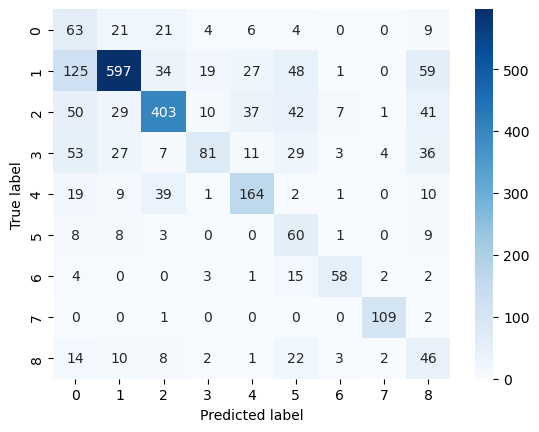

In [181]:
final_nb = MultinomialNB(**grid_search_nb.best_params_)
start_time = time.time()
final_nb.fit(X_train_all_positive, y_train_all)
end_time = time.time()
training_time = end_time - start_time
print("Training time: ", training_time)

# Evaluate the final classifier on the test set
start_time = time.time()
y_pred = final_nb.predict(X_evaluation_positive)
end_time = time.time()
testing_time = end_time - start_time
print("Testing time: ", testing_time)

test_score = f1_score(y_evaluation, y_pred, average='macro')
print("Test score (macro f1): ", test_score)

print("Accuracy:", accuracy_score(y_evaluation, y_pred))
print("Precision:", precision_score(y_evaluation, y_pred, average='macro'))
print("Recall:", recall_score(y_evaluation, y_pred, average='macro'))
print("F1-score:", f1_score(y_evaluation, y_pred, average='macro'))
print("Confusion matrix:")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_evaluation, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')


#### 3.5 KNN

In [171]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, make_scorer
import time

# Create a KNN classifier object
KNN = KNeighborsClassifier()

# Define the scoring function as macro f1
scorer = make_scorer(f1_score, average='macro')

# Define the hyperparameters to tune
grid_search_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto'],
    'leaf_size': [10, 20, 30],
}

# Set up the GridSearchCV object with the scorer
grid_search_knn = GridSearchCV(
    estimator=KNN,
    param_grid=grid_search_params,
    cv=kf,
    n_jobs=-1,
    scoring=scorer
)

# Fit the grid search to the training data
grid_search_knn.fit(X_train_all, y_train_all)

# Print out the performance for each combination of hyperparameters
cv_results = grid_search_knn.cv_results_
for i in range(len(cv_results['params'])):
    print("Hyperparameters: ", cv_results['params'][i])
    print("Mean cross-validation score (macro f1): ", cv_results['mean_test_score'][i])

print("-----------------------------------------------------------------------------------------")
print("Best hyperparameters: ", grid_search_knn.best_params_)
print("Best performance in 5-fold cross validation (macro f1): ", grid_search_knn.best_score_)


Hyperparameters:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'uniform'}
Mean cross-validation score (macro f1):  0.6224429172911906
Hyperparameters:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'weights': 'distance'}
Mean cross-validation score (macro f1):  0.6353352849684487
Hyperparameters:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 5, 'weights': 'uniform'}
Mean cross-validation score (macro f1):  0.6094034554790662
Hyperparameters:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 5, 'weights': 'distance'}
Mean cross-validation score (macro f1):  0.6379511561781869
Hyperparameters:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'weights': 'uniform'}
Mean cross-validation score (macro f1):  0.59886506171967
Hyperparameters:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 7, 'weights': 'distance'}
Mean cross-validation score (macro f1):  0.6232917520196285
Hyperparameters:  {'algorithm': 'auto', 'leaf_size': 20, 

Training time:  0.004000425338745117
Testing time:  0.16001439094543457
Test score (macro f1):  0.648800325667588
Accuracy: 0.6915227629513344
Precision: 0.6773420239623832
Recall: 0.636053713211625
F1-score: 0.648800325667588
Confusion matrix:


Text(50.722222222222214, 0.5, 'True label')

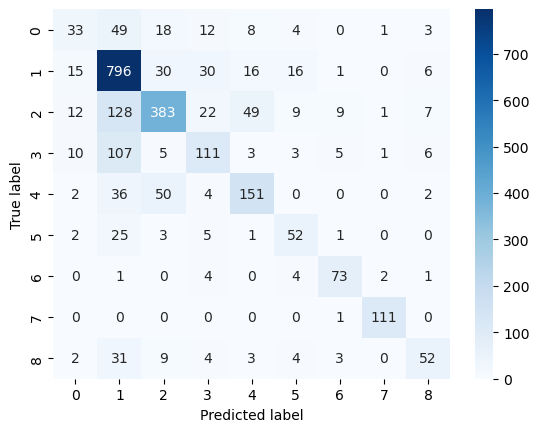

In [172]:

final_knn = KNeighborsClassifier(**grid_search_knn.best_params_)
start_time = time.time()
final_knn.fit(X_train_all, y_train_all)
end_time = time.time()
training_time = end_time - start_time
print("Training time: ", training_time)

# Evaluate the final classifier on the test set
start_time = time.time()
y_pred = final_knn.predict(X_evaluation)
end_time = time.time()
testing_time = end_time - start_time
print("Testing time: ", testing_time)

test_score = f1_score(y_evaluation, y_pred, average='macro')
print("Test score (macro f1): ", test_score)

print("Accuracy:", accuracy_score(y_evaluation, y_pred))
print("Precision:", precision_score(y_evaluation, y_pred, average='macro'))
print("Recall:", recall_score(y_evaluation, y_pred, average='macro'))
print("F1-score:", f1_score(y_evaluation, y_pred, average='macro'))
print("Confusion matrix:")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_evaluation, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')


#### 3.6 QDA

In [186]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Create a QDA classifier object
QDA = QuadraticDiscriminantAnalysis()


# Define the scoring function as macro f1
scorer = make_scorer(f1_score, average='macro')



#Define the hyperparameters to tune
grid_search_params = {
    'reg_param': [0.0, 0.1, 0.5, 1.0],
    'store_covariance': [True, False],
    'tol': [1e-3, 1e-4, 1e-5]
    
}


# Set up the GridSearchCV object with the scorer
grid_search_qda = GridSearchCV(
    estimator=QDA,
    param_grid=grid_search_params,
    cv=kf,
    n_jobs=-1,
    scoring=scorer
)

# Fit the grid search to the training data
grid_search_qda.fit(X_train_all_positive, y_train_all)

# Print out the performance for each combination of hyperparameters
cv_results = grid_search_qda.cv_results_
for i in range(len(cv_results['params'])):
    print("Hyperparameters: ", cv_results['params'][i])
    print("Mean cross-validation score (macro f1): ", cv_results['mean_test_score'][i])

print("-----------------------------------------------------------------------------------------")
print("Best hyperparameters: ", grid_search_qda.best_params_)
print("Best performance in 5-fold cross validation (macro f1): ", grid_search_qda.best_score_)


Hyperparameters:  {'reg_param': 0.0, 'store_covariance': True, 'tol': 0.001}
Mean cross-validation score (macro f1):  0.6070307452152996
Hyperparameters:  {'reg_param': 0.0, 'store_covariance': True, 'tol': 0.0001}
Mean cross-validation score (macro f1):  0.6070307452152996
Hyperparameters:  {'reg_param': 0.0, 'store_covariance': True, 'tol': 1e-05}
Mean cross-validation score (macro f1):  0.6070307452152996
Hyperparameters:  {'reg_param': 0.0, 'store_covariance': False, 'tol': 0.001}
Mean cross-validation score (macro f1):  0.6070307452152996
Hyperparameters:  {'reg_param': 0.0, 'store_covariance': False, 'tol': 0.0001}
Mean cross-validation score (macro f1):  0.6070307452152996
Hyperparameters:  {'reg_param': 0.0, 'store_covariance': False, 'tol': 1e-05}
Mean cross-validation score (macro f1):  0.6070307452152996
Hyperparameters:  {'reg_param': 0.1, 'store_covariance': True, 'tol': 0.001}
Mean cross-validation score (macro f1):  0.19051140893477328
Hyperparameters:  {'reg_param': 0.1

Training time:  2.5068509578704834
Testing time:  0.028246641159057617
Test score (macro f1):  0.649108263807066
Accuracy: 0.7103610675039247
Precision: 0.7491668318949658
Recall: 0.6048989784009515
F1-score: 0.649108263807066
Confusion matrix:


Text(50.722222222222214, 0.5, 'True label')

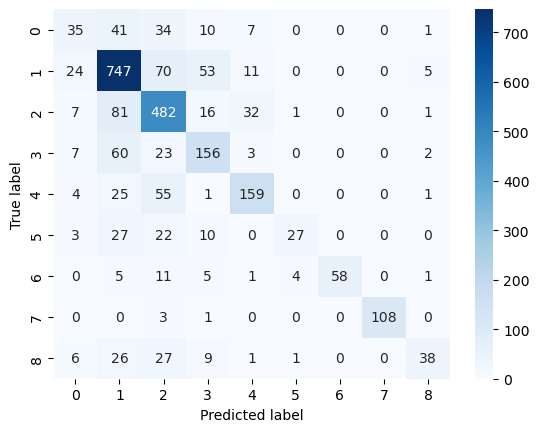

In [187]:
# Create a final QDA classifier object with the best hyperparameters
final_qda = QuadraticDiscriminantAnalysis(**grid_search_qda.best_params_)

# Train the final QDA classifier on all of the training data
start_time = time.time()
final_qda.fit(X_train_all, y_train_all)
end_time = time.time()
training_time = end_time - start_time
print("Training time: ", training_time)

# Evaluate the final classifier on the test set
start_time = time.time()
y_pred = final_qda.predict(X_evaluation)
end_time = time.time()
testing_time = end_time - start_time
print("Testing time: ", testing_time)

test_score = f1_score(y_evaluation, y_pred, average='macro')
print("Test score (macro f1): ", test_score)

print("Accuracy:", accuracy_score(y_evaluation, y_pred))
print("Precision:", precision_score(y_evaluation, y_pred, average='macro'))
print("Recall:", recall_score(y_evaluation, y_pred, average='macro'))
print("F1-score:", f1_score(y_evaluation, y_pred, average='macro'))
print("Confusion matrix:")

cm = confusion_matrix(y_evaluation, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')

#### 3.7 CatBoost

In [4]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

# Define the scoring function as macro f1
scorer = make_scorer(f1_score, average='macro')

# Define the CatBoost classifier object
catboost = CatBoostClassifier()

# Define the hyperparameters to tune
grid_search_params = {
    'iterations': [50,100,500],
    'learning_rate': [0.01, 0.1],
}

# Set up the GridSearchCV object with the scorer
grid_search_catboost = GridSearchCV(
    estimator=catboost,
    param_grid=grid_search_params,
    cv=kf,
    n_jobs=-1,
    scoring=scorer
)

# Fit the grid search to the training data
grid_search_catboost.fit(X_train_all, y_train_all)

# Print out the performance for each combination of hyperparameters
cv_results = grid_search_catboost.cv_results_
for i in range(len(cv_results['params'])):
    print("Hyperparameters: ", cv_results['params'][i])
    print("Mean cross-validation score (macro f1): ", cv_results['mean_test_score'][i])

print("-----------------------------------------------------------------------------------------")
print("Best hyperparameters: ", grid_search_catboost.best_params_)
print("Best performance in 5-fold cross validation (macro f1): ", grid_search_catboost.best_score_)




0:	learn: 2.0183451	total: 242ms	remaining: 2m
1:	learn: 1.8844495	total: 330ms	remaining: 1m 22s
2:	learn: 1.7939018	total: 420ms	remaining: 1m 9s
3:	learn: 1.7286285	total: 512ms	remaining: 1m 3s
4:	learn: 1.6683548	total: 597ms	remaining: 59.1s
5:	learn: 1.6193401	total: 683ms	remaining: 56.2s
6:	learn: 1.5701532	total: 771ms	remaining: 54.3s
7:	learn: 1.5298858	total: 857ms	remaining: 52.7s
8:	learn: 1.4965545	total: 947ms	remaining: 51.7s
9:	learn: 1.4648051	total: 1.03s	remaining: 50.6s
10:	learn: 1.4335042	total: 1.13s	remaining: 50.1s
11:	learn: 1.4064188	total: 1.21s	remaining: 49.4s
12:	learn: 1.3808462	total: 1.3s	remaining: 48.7s
13:	learn: 1.3616590	total: 1.39s	remaining: 48.2s
14:	learn: 1.3416324	total: 1.48s	remaining: 47.7s
15:	learn: 1.3303970	total: 1.56s	remaining: 47.3s
16:	learn: 1.3116567	total: 1.65s	remaining: 46.9s
17:	learn: 1.2961210	total: 1.74s	remaining: 46.6s
18:	learn: 1.2829052	total: 1.82s	remaining: 46.2s
19:	learn: 1.2708409	total: 1.92s	remaining:

162:	learn: 0.6624907	total: 14.4s	remaining: 29.7s
163:	learn: 0.6614536	total: 14.5s	remaining: 29.6s
164:	learn: 0.6590538	total: 14.6s	remaining: 29.5s
165:	learn: 0.6575221	total: 14.6s	remaining: 29.4s
166:	learn: 0.6557878	total: 14.7s	remaining: 29.3s
167:	learn: 0.6537304	total: 14.8s	remaining: 29.3s
168:	learn: 0.6517255	total: 14.9s	remaining: 29.2s
169:	learn: 0.6497394	total: 15s	remaining: 29.1s
170:	learn: 0.6473948	total: 15.1s	remaining: 29s
171:	learn: 0.6451148	total: 15.2s	remaining: 28.9s
172:	learn: 0.6431498	total: 15.2s	remaining: 28.8s
173:	learn: 0.6402726	total: 15.3s	remaining: 28.7s
174:	learn: 0.6382722	total: 15.4s	remaining: 28.6s
175:	learn: 0.6365133	total: 15.5s	remaining: 28.5s
176:	learn: 0.6339059	total: 15.6s	remaining: 28.4s
177:	learn: 0.6321115	total: 15.7s	remaining: 28.3s
178:	learn: 0.6305012	total: 15.8s	remaining: 28.2s
179:	learn: 0.6289366	total: 15.8s	remaining: 28.1s
180:	learn: 0.6275557	total: 15.9s	remaining: 28.1s
181:	learn: 0.62

321:	learn: 0.4378160	total: 28s	remaining: 15.5s
322:	learn: 0.4370297	total: 28s	remaining: 15.4s
323:	learn: 0.4365756	total: 28.1s	remaining: 15.3s
324:	learn: 0.4359940	total: 28.2s	remaining: 15.2s
325:	learn: 0.4354036	total: 28.3s	remaining: 15.1s
326:	learn: 0.4340768	total: 28.4s	remaining: 15s
327:	learn: 0.4334303	total: 28.5s	remaining: 14.9s
328:	learn: 0.4322089	total: 28.6s	remaining: 14.8s
329:	learn: 0.4312166	total: 28.6s	remaining: 14.8s
330:	learn: 0.4299333	total: 28.7s	remaining: 14.7s
331:	learn: 0.4285523	total: 28.8s	remaining: 14.6s
332:	learn: 0.4278227	total: 28.9s	remaining: 14.5s
333:	learn: 0.4270438	total: 29s	remaining: 14.4s
334:	learn: 0.4263299	total: 29.1s	remaining: 14.3s
335:	learn: 0.4257336	total: 29.1s	remaining: 14.2s
336:	learn: 0.4249370	total: 29.2s	remaining: 14.1s
337:	learn: 0.4244703	total: 29.3s	remaining: 14s
338:	learn: 0.4236204	total: 29.4s	remaining: 14s
339:	learn: 0.4229648	total: 29.5s	remaining: 13.9s
340:	learn: 0.4218359	to

482:	learn: 0.3215209	total: 41.8s	remaining: 1.47s
483:	learn: 0.3209749	total: 41.9s	remaining: 1.39s
484:	learn: 0.3205394	total: 42s	remaining: 1.3s
485:	learn: 0.3202712	total: 42.1s	remaining: 1.21s
486:	learn: 0.3198802	total: 42.2s	remaining: 1.13s
487:	learn: 0.3192023	total: 42.3s	remaining: 1.04s
488:	learn: 0.3188450	total: 42.3s	remaining: 952ms
489:	learn: 0.3181612	total: 42.4s	remaining: 866ms
490:	learn: 0.3175606	total: 42.5s	remaining: 779ms
491:	learn: 0.3171260	total: 42.6s	remaining: 693ms
492:	learn: 0.3165175	total: 42.7s	remaining: 606ms
493:	learn: 0.3160699	total: 42.8s	remaining: 519ms
494:	learn: 0.3157921	total: 42.8s	remaining: 433ms
495:	learn: 0.3155181	total: 42.9s	remaining: 346ms
496:	learn: 0.3143203	total: 43s	remaining: 260ms
497:	learn: 0.3139152	total: 43.1s	remaining: 173ms
498:	learn: 0.3131918	total: 43.2s	remaining: 86.5ms
499:	learn: 0.3128366	total: 43.3s	remaining: 0us
Hyperparameters:  {'iterations': 50, 'learning_rate': 0.01}
Mean cross

0:	learn: 2.0183451	total: 146ms	remaining: 1m 13s
1:	learn: 1.8844495	total: 239ms	remaining: 59.5s
2:	learn: 1.7939018	total: 328ms	remaining: 54.4s
3:	learn: 1.7286285	total: 415ms	remaining: 51.5s
4:	learn: 1.6683548	total: 499ms	remaining: 49.4s
5:	learn: 1.6193401	total: 588ms	remaining: 48.4s
6:	learn: 1.5701532	total: 676ms	remaining: 47.6s
7:	learn: 1.5298858	total: 760ms	remaining: 46.7s
8:	learn: 1.4965545	total: 848ms	remaining: 46.3s
9:	learn: 1.4648051	total: 936ms	remaining: 45.9s
10:	learn: 1.4335042	total: 1.02s	remaining: 45.6s
11:	learn: 1.4064188	total: 1.11s	remaining: 45.3s
12:	learn: 1.3808462	total: 1.2s	remaining: 45s
13:	learn: 1.3616590	total: 1.29s	remaining: 44.9s
14:	learn: 1.3416324	total: 1.39s	remaining: 45s
15:	learn: 1.3303970	total: 1.48s	remaining: 44.6s
16:	learn: 1.3116567	total: 1.56s	remaining: 44.4s
17:	learn: 1.2961210	total: 1.65s	remaining: 44.2s
18:	learn: 1.2829052	total: 1.75s	remaining: 44.4s
19:	learn: 1.2708409	total: 1.84s	remaining: 

161:	learn: 0.6648470	total: 14.2s	remaining: 29.5s
162:	learn: 0.6624907	total: 14.2s	remaining: 29.4s
163:	learn: 0.6614536	total: 14.3s	remaining: 29.4s
164:	learn: 0.6590538	total: 14.4s	remaining: 29.3s
165:	learn: 0.6575221	total: 14.5s	remaining: 29.2s
166:	learn: 0.6557878	total: 14.6s	remaining: 29.1s
167:	learn: 0.6537304	total: 14.7s	remaining: 29s
168:	learn: 0.6517255	total: 14.8s	remaining: 28.9s
169:	learn: 0.6497394	total: 14.8s	remaining: 28.8s
170:	learn: 0.6473948	total: 14.9s	remaining: 28.7s
171:	learn: 0.6451148	total: 15s	remaining: 28.6s
172:	learn: 0.6431498	total: 15.1s	remaining: 28.5s
173:	learn: 0.6402726	total: 15.2s	remaining: 28.5s
174:	learn: 0.6382722	total: 15.3s	remaining: 28.4s
175:	learn: 0.6365133	total: 15.4s	remaining: 28.3s
176:	learn: 0.6339059	total: 15.4s	remaining: 28.2s
177:	learn: 0.6321115	total: 15.5s	remaining: 28.1s
178:	learn: 0.6305012	total: 15.6s	remaining: 28s
179:	learn: 0.6289366	total: 15.7s	remaining: 27.9s
180:	learn: 0.6275

320:	learn: 0.4389936	total: 27.8s	remaining: 15.5s
321:	learn: 0.4378160	total: 27.9s	remaining: 15.4s
322:	learn: 0.4370297	total: 28s	remaining: 15.3s
323:	learn: 0.4365756	total: 28.1s	remaining: 15.2s
324:	learn: 0.4359940	total: 28.1s	remaining: 15.2s
325:	learn: 0.4354036	total: 28.2s	remaining: 15.1s
326:	learn: 0.4340768	total: 28.3s	remaining: 15s
327:	learn: 0.4334303	total: 28.4s	remaining: 14.9s
328:	learn: 0.4322089	total: 28.5s	remaining: 14.8s
329:	learn: 0.4312166	total: 28.6s	remaining: 14.7s
330:	learn: 0.4299333	total: 28.7s	remaining: 14.6s
331:	learn: 0.4285523	total: 28.7s	remaining: 14.5s
332:	learn: 0.4278227	total: 28.8s	remaining: 14.5s
333:	learn: 0.4270438	total: 28.9s	remaining: 14.4s
334:	learn: 0.4263299	total: 29s	remaining: 14.3s
335:	learn: 0.4257336	total: 29.1s	remaining: 14.2s
336:	learn: 0.4249370	total: 29.2s	remaining: 14.1s
337:	learn: 0.4244703	total: 29.2s	remaining: 14s
338:	learn: 0.4236204	total: 29.3s	remaining: 13.9s
339:	learn: 0.422964

479:	learn: 0.3234738	total: 41.3s	remaining: 1.72s
480:	learn: 0.3226671	total: 41.4s	remaining: 1.63s
481:	learn: 0.3221675	total: 41.5s	remaining: 1.55s
482:	learn: 0.3215209	total: 41.6s	remaining: 1.46s
483:	learn: 0.3209749	total: 41.6s	remaining: 1.38s
484:	learn: 0.3205394	total: 41.7s	remaining: 1.29s
485:	learn: 0.3202712	total: 41.8s	remaining: 1.2s
486:	learn: 0.3198802	total: 41.9s	remaining: 1.12s
487:	learn: 0.3192023	total: 42s	remaining: 1.03s
488:	learn: 0.3188450	total: 42.1s	remaining: 946ms
489:	learn: 0.3181612	total: 42.1s	remaining: 860ms
490:	learn: 0.3175606	total: 42.2s	remaining: 774ms
491:	learn: 0.3171260	total: 42.3s	remaining: 688ms
492:	learn: 0.3165175	total: 42.4s	remaining: 602ms
493:	learn: 0.3160699	total: 42.5s	remaining: 516ms
494:	learn: 0.3157921	total: 42.6s	remaining: 430ms
495:	learn: 0.3155181	total: 42.6s	remaining: 344ms
496:	learn: 0.3143203	total: 42.7s	remaining: 258ms
497:	learn: 0.3139152	total: 42.8s	remaining: 172ms
498:	learn: 0.3

Text(50.722222222222214, 0.5, 'True label')

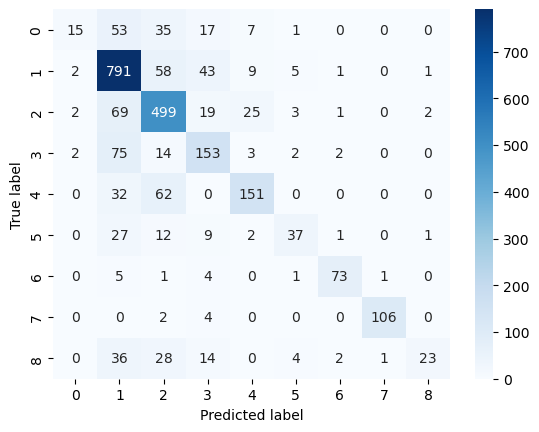

In [5]:
import time
# Train the final classifier on the entire training set using the best hyperparameters
final_catboost = CatBoostClassifier(**grid_search_catboost.best_params_)

start_time = time.time()
final_catboost.fit(X_train_all, y_train_all)
end_time = time.time()
training_time = end_time - start_time
print("Training time: ", training_time)

# Evaluate the final classifier on the test set
start_time = time.time()
y_pred = final_catboost.predict(X_evaluation)
end_time = time.time()
testing_time = end_time - start_time
print("Testing time: ", testing_time)

test_score = f1_score(y_evaluation, y_pred, average='macro')
print("Test score (macro f1): ", test_score)

print("Accuracy:", accuracy_score(y_evaluation, y_pred))
print("Precision:", precision_score(y_evaluation, y_pred, average='macro'))
print("Recall:", recall_score(y_evaluation, y_pred, average='macro'))
print("F1-score:", f1_score(y_evaluation, y_pred, average='macro'))
print("Confusion matrix:")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_evaluation, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')

#### 3.8 Multilayer Perceptron

In [4]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler



# Define the scoring function as macro f1
scorer = make_scorer(f1_score, average='macro')

# Define the MLP classifier object
MLP = MLPClassifier()

#Define the hyperparameters to tune
grid_search_params = {
    'hidden_layer_sizes': [(50,),(100,),(500,),(1000,),(50,30,),(100,50,),(500,200,),(50,30,20,)],
    'activation': ['relu', 'logistic'],
    'solver': ['lbfgs',  'adam']
}




# Set up the GridSearchCV object with the scorer
grid_search_mlp = GridSearchCV(
    estimator=MLP,
    param_grid=grid_search_params,
    cv=kf,
    n_jobs=-1,
    scoring=scorer
)

# Fit the grid search to the training data
grid_search_mlp.fit(X_train_all, y_train_all)

# Print out the performance for each combination of hyperparameters
cv_results = grid_search_mlp.cv_results_
for i in range(len(cv_results['params'])):
    print("Hyperparameters: ", cv_results['params'][i])
    print("Mean cross-validation score (macro f1): ", cv_results['mean_test_score'][i])

print("-----------------------------------------------------------------------------------------")
print("Best hyperparameters: ", grid_search_mlp.best_params_)
print("Best performance in 5-fold cross validation (macro f1): ", grid_search_mlp.best_score_)


Hyperparameters:  {'activation': 'relu', 'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}
Mean cross-validation score (macro f1):  0.6218509156591677
Hyperparameters:  {'activation': 'relu', 'hidden_layer_sizes': (50,), 'solver': 'adam'}
Mean cross-validation score (macro f1):  0.6555820148235988
Hyperparameters:  {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'lbfgs'}
Mean cross-validation score (macro f1):  0.647048240356242
Hyperparameters:  {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Mean cross-validation score (macro f1):  0.6781780006380916
Hyperparameters:  {'activation': 'relu', 'hidden_layer_sizes': (500,), 'solver': 'lbfgs'}
Mean cross-validation score (macro f1):  0.6730883193624306
Hyperparameters:  {'activation': 'relu', 'hidden_layer_sizes': (500,), 'solver': 'adam'}
Mean cross-validation score (macro f1):  0.7181692966109023
Hyperparameters:  {'activation': 'relu', 'hidden_layer_sizes': (1000,), 'solver': 'lbfgs'}
Mean cross-vali

Training time:  39.62852692604065
Testing time:  0.015989303588867188
Test score (macro f1):  0.7261267079275855
Accuracy: 0.7672684458398744
Precision: 0.745549100713935
Recall: 0.7115043237869118
F1-score: 0.7261267079275855
Confusion matrix:


Text(50.722222222222214, 0.5, 'True label')

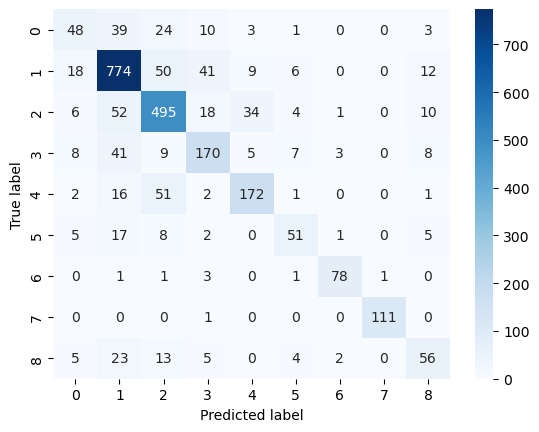

In [5]:
import time

# Train the final classifier on the entire training set using the best hyperparameters
final_mlp = MLPClassifier(**grid_search_mlp.best_params_)
start_time = time.time()
final_mlp.fit(X_train_all, y_train_all)
end_time = time.time()
training_time = end_time - start_time
print("Training time: ", training_time)

# Evaluate the final classifier on the test set
start_time = time.time()
y_pred = final_mlp.predict(X_evaluation)
end_time = time.time()
testing_time = end_time - start_time
print("Testing time: ", testing_time)

test_score = f1_score(y_evaluation, y_pred, average='macro')
print("Test score (macro f1): ", test_score)

print("Accuracy:", accuracy_score(y_evaluation, y_pred))
print("Precision:", precision_score(y_evaluation, y_pred, average='macro'))
print("Recall:", recall_score(y_evaluation, y_pred, average='macro'))
print("F1-score:", f1_score(y_evaluation, y_pred, average='macro'))
print("Confusion matrix:")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_evaluation, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')


#### 3.9XGBoost

In [5]:
import xgboost as xgb
from xgboost import XGBClassifier
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

XGBoost_model = XGBClassifier()

# Define the scoring function as micro f1
scorer = make_scorer(f1_score, average='macro')

#Define the hyperparameters to tune
param_grid_XGBoost = {
    'n_estimators': [200,500],
    'max_depth': [5, 7, None],
}


# Set up the GridSearchCV object with the scorer
grid_search_XGBoost = GridSearchCV(
    estimator=XGBoost_model,
    param_grid=param_grid_XGBoost,
    cv=kf,
    n_jobs=-1,
    scoring=scorer
)

# Fit the grid search to the training data
grid_search_XGBoost.fit(X_train_all, y_train_all)

# Print out the performance for each combination of hyperparameters
cv_results = grid_search_XGBoost.cv_results_
for i in range(len(cv_results['params'])):
    print("Hyperparameters: ", cv_results['params'][i])
    print("Mean cross-validation score (macro f1): ", cv_results['mean_test_score'][i])

print("-----------------------------------------------------------------------------------------")
print("Best hyperparameters: ", grid_search_XGBoost.best_params_)
print("Best performance in 5-fold cross validation (macro f1): ", grid_search_XGBoost.best_score_)





Hyperparameters:  {'max_depth': 5, 'n_estimators': 200}
Mean cross-validation score (macro f1):  0.6169120288510787
Hyperparameters:  {'max_depth': 5, 'n_estimators': 500}
Mean cross-validation score (macro f1):  0.6290077173840094
Hyperparameters:  {'max_depth': 7, 'n_estimators': 200}
Mean cross-validation score (macro f1):  0.6209578651726337
Hyperparameters:  {'max_depth': 7, 'n_estimators': 500}
Mean cross-validation score (macro f1):  0.6278184693935199
Hyperparameters:  {'max_depth': None, 'n_estimators': 200}
Mean cross-validation score (macro f1):  0.622257014677521
Hyperparameters:  {'max_depth': None, 'n_estimators': 500}
Mean cross-validation score (macro f1):  0.6303818011735993
-----------------------------------------------------------------------------------------
Best hyperparameters:  {'max_depth': None, 'n_estimators': 500}
Best performance in 5-fold cross validation (macro f1):  0.6303818011735993


Training time:  64.05673170089722
Testing time:  0.07052302360534668
Test score (macro f1):  0.642381901053651
Accuracy: 0.7244897959183674
Precision: 0.7421000020510184
Recall: 0.6094978926598911
F1-score: 0.642381901053651
Confusion matrix:


Text(50.722222222222214, 0.5, 'True label')

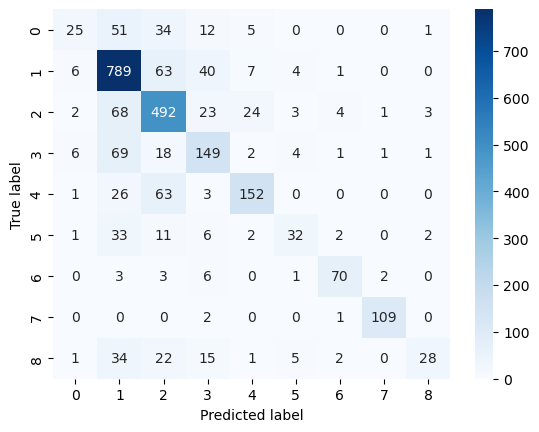

In [6]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
# Train the final classifier on the entire training set using the best hyperparameters
final_xgb = XGBClassifier(**grid_search_XGBoost.best_params_)
start_time = time.time()
final_xgb.fit(X_train_all, y_train_all)
end_time = time.time()
training_time = end_time - start_time
print("Training time: ", training_time)

# Evaluate the final classifier on the test set
start_time = time.time()
y_pred = final_xgb.predict(X_evaluation)
end_time = time.time()
testing_time = end_time - start_time
print("Testing time: ", testing_time)

test_score = f1_score(y_evaluation, y_pred, average='macro')
print("Test score (macro f1): ", test_score)

print("Accuracy:", accuracy_score(y_evaluation, y_pred))
print("Precision:", precision_score(y_evaluation, y_pred, average='macro'))
print("Recall:", recall_score(y_evaluation, y_pred, average='macro'))
print("F1-score:", f1_score(y_evaluation, y_pred, average='macro'))
print("Confusion matrix:")


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_evaluation, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')



## Insight and improvement

#### Comparison the feature selection effectively imporved the model performance


In [19]:
Y2_after_dropped_array_withoutFeatureSelection = Y2_after_dropped.values

X_withoutFeatureSelection = X_before_PCA.values
np.save('Y2_after_dropped_array_withoutFeatureSelection.npy', Y2_after_dropped_array_withoutFeatureSelection)
np.save('X_withoutFeatureSelection.npy',X_withoutFeatureSelection)

(10192, 9)


In [21]:
import numpy as np
Y2_after_dropped_array = np.load('Y2_after_dropped_array_withoutFeatureSelection.npy')
X_FinalArray = np.load('X_withoutFeatureSelection.npy')
print(X_FinalArray.shape)
print(Y2_after_dropped_array.shape)

(10192, 874)
(10192, 9)


#### Use models with the best perfomance in the above part which are SVM, NN and LR to do the comparisons

In [24]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer
import time

SVM = SVC()

# Define the scoring function as micro f1
scorer = make_scorer(f1_score, average='macro')

# Define the hyperparameters to tune
grid_search_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Set up the GridSearchCV object with the scorer
grid_search_svm = GridSearchCV(
    estimator=SVM,
    param_grid=grid_search_params,
    cv=kf,
    n_jobs=-1,
    scoring=scorer
)

# Fit the grid search to the training data
grid_search_svm.fit(X_train_all, y_train_all)

# Print out the performance for each combination of hyperparameters
cv_results = grid_search_svm.cv_results_
for i in range(len(cv_results['params'])):
    print("Hyperparameters: ", cv_results['params'][i])
    print("Mean cross-validation score (macro f1): ", cv_results['mean_test_score'][i])

print("-----------------------------------------------------------------------------------------")
print("Best hyperparameters: ", grid_search_svm.best_params_)
print("Best performance in 5-fold cross validation (macro f1): ", grid_search_svm.best_score_)





Hyperparameters:  {'C': 0.1, 'kernel': 'linear'}
Mean cross-validation score (macro f1):  0.6284893694435957
Hyperparameters:  {'C': 0.1, 'kernel': 'poly'}
Mean cross-validation score (macro f1):  0.5650769196420857
Hyperparameters:  {'C': 0.1, 'kernel': 'rbf'}
Mean cross-validation score (macro f1):  0.32996590853956664
Hyperparameters:  {'C': 0.1, 'kernel': 'sigmoid'}
Mean cross-validation score (macro f1):  0.05610066654497563
Hyperparameters:  {'C': 1, 'kernel': 'linear'}
Mean cross-validation score (macro f1):  0.6721977104193608
Hyperparameters:  {'C': 1, 'kernel': 'poly'}
Mean cross-validation score (macro f1):  0.6800689477795979
Hyperparameters:  {'C': 1, 'kernel': 'rbf'}
Mean cross-validation score (macro f1):  0.5376176501841117
Hyperparameters:  {'C': 1, 'kernel': 'sigmoid'}
Mean cross-validation score (macro f1):  0.05610066654497563
Hyperparameters:  {'C': 10, 'kernel': 'linear'}
Mean cross-validation score (macro f1):  0.6537546546757029
Hyperparameters:  {'C': 10, 'kern

Training time:  12.325547218322754
Testing time:  4.0154078006744385
Test score (macro f1):  0.688863440885192
Accuracy: 0.7405808477237049
Precision: 0.7076516155583628
Recall: 0.6751284369154068
F1-score: 0.688863440885192
Confusion matrix:
[[ 42  40  24  12   4   2   0   0   4]
 [ 26 769  48  41   7   6   1   1  11]
 [ 18  67 482  11  17  12   3   0  10]
 [ 15  58  15 147   4   4   1   0   7]
 [  9  17  50   2 165   1   0   0   1]
 [  2  20  11   3   1  46   3   0   3]
 [  1   0   1   2   0   1  80   0   0]
 [  0   0   0   3   0   0   0 109   0]
 [  4  22  15   9   1   8   2   0  47]]


Text(50.722222222222214, 0.5, 'True label')

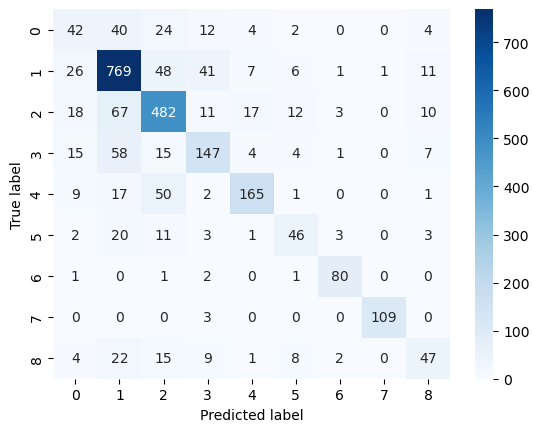

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create the final classifier with the best hyperparameters
final_svm = SVC(**grid_search_svm.best_params_)
start_time = time.time()
final_svm.fit(X_train_all, y_train_all)
end_time = time.time()
training_time = end_time - start_time
print("Training time: ", training_time)

# Evaluate the final classifier on the test set
start_time = time.time()
y_pred = final_svm.predict(X_evaluation)
end_time = time.time()
testing_time = end_time - start_time
print("Testing time: ", testing_time)

test_score = f1_score(y_evaluation, y_pred, average='macro')
print("Test score (macro f1): ", test_score)


print("Accuracy:", accuracy_score(y_evaluation, y_pred))
print("Precision:", precision_score(y_evaluation, y_pred, average='macro'))
print("Recall:", recall_score(y_evaluation, y_pred, average='macro'))
print("F1-score:", f1_score(y_evaluation, y_pred, average='macro'))
print("Confusion matrix:")
print(confusion_matrix(y_evaluation, y_pred))




from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_evaluation, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')


#### LR

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
import time

LR = LogisticRegression(max_iter=100000000)

# Define the scoring function as macro f1
scorer = make_scorer(f1_score, average='macro')

# Define the hyperparameters to tune
grid_search_params = {
    'C': [0.1, 1, 10,50],
    'solver': ['saga', 'sag'],
    'multi_class': ['ovr', 'multinomial']
}

# Set up the GridSearchCV object with the scorer
grid_search_lr = GridSearchCV(
    estimator=LR,
    param_grid=grid_search_params,
    cv=kf,
    n_jobs=-1,
    scoring=scorer
)

# Fit the grid search to the training data
grid_search_lr.fit(X_train_all, y_train_all)

# Print out the performance for each combination of hyperparameters
cv_results = grid_search_lr.cv_results_
for i in range(len(cv_results['params'])):
    print("Hyperparameters: ", cv_results['params'][i])
    print("Mean cross-validation score (macro f1): ", cv_results['mean_test_score'][i])

print("-----------------------------------------------------------------------------------------")
print("Best hyperparameters: ", grid_search_lr.best_params_)
print("Best performance in 5-fold cross validation (macro f1): ", grid_search_lr.best_score_)






Hyperparameters:  {'C': 0.1, 'multi_class': 'ovr', 'solver': 'saga'}
Mean cross-validation score (macro f1):  0.5681885882732931
Hyperparameters:  {'C': 0.1, 'multi_class': 'ovr', 'solver': 'sag'}
Mean cross-validation score (macro f1):  0.5682381621815502
Hyperparameters:  {'C': 0.1, 'multi_class': 'multinomial', 'solver': 'saga'}
Mean cross-validation score (macro f1):  0.5946893430629677
Hyperparameters:  {'C': 0.1, 'multi_class': 'multinomial', 'solver': 'sag'}
Mean cross-validation score (macro f1):  0.5946199951218036
Hyperparameters:  {'C': 1, 'multi_class': 'ovr', 'solver': 'saga'}
Mean cross-validation score (macro f1):  0.6588182195756347
Hyperparameters:  {'C': 1, 'multi_class': 'ovr', 'solver': 'sag'}
Mean cross-validation score (macro f1):  0.6590208289499141
Hyperparameters:  {'C': 1, 'multi_class': 'multinomial', 'solver': 'saga'}
Mean cross-validation score (macro f1):  0.6700506600008869
Hyperparameters:  {'C': 1, 'multi_class': 'multinomial', 'solver': 'sag'}
Mean cro

Training time:  392.9451012611389
Testing time:  0.005001068115234375
Test score (macro f1):  0.6645632275107778
Accuracy: 0.7319466248037677
Precision: 0.6999088449898734
Recall: 0.6455857434416364
F1-score: 0.6645632275107778
Confusion matrix:


Text(50.722222222222214, 0.5, 'True label')

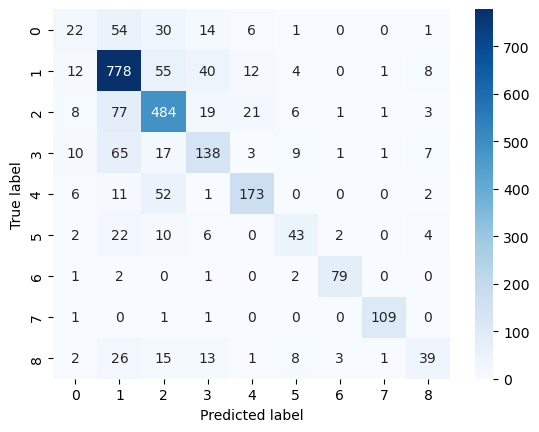

In [31]:
# Create the final classifier with the best hyperparameters
final_lr = LogisticRegression(**grid_search_lr.best_params_,max_iter=100000000)
start_time = time.time()
final_lr.fit(X_train_all, y_train_all)
end_time = time.time()
training_time = end_time - start_time
print("Training time: ", training_time)

# Evaluate the final classifier on the test set
start_time = time.time()
y_pred = final_lr.predict(X_evaluation)
end_time = time.time()
testing_time = end_time - start_time
print("Testing time: ", testing_time)

test_score = f1_score(y_evaluation, y_pred, average='macro')
print("Test score (macro f1): ", test_score)

print("Accuracy:", accuracy_score(y_evaluation, y_pred))
print("Precision:", precision_score(y_evaluation, y_pred, average='macro'))
print("Recall:", recall_score(y_evaluation, y_pred, average='macro'))
print("F1-score:", f1_score(y_evaluation, y_pred, average='macro'))
print("Confusion matrix:")
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_evaluation, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')


#### Multilayer perceptron

In [32]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler



# Define the scoring function as macro f1
scorer = make_scorer(f1_score, average='macro')

# Define the MLP classifier object
MLP = MLPClassifier()

#Define the hyperparameters to tune
grid_search_params = {
    'hidden_layer_sizes': [(50,),(100,),(500,),(1000,),(50,30,),(100,50,),(500,200,),(50,30,20,)],
    'activation': ['relu', 'logistic'],
    'solver': ['lbfgs',  'adam']
}




# Set up the GridSearchCV object with the scorer
grid_search_mlp = GridSearchCV(
    estimator=MLP,
    param_grid=grid_search_params,
    cv=kf,
    n_jobs=-1,
    scoring=scorer
)

# Fit the grid search to the training data
grid_search_mlp.fit(X_train_all, y_train_all)

# Print out the performance for each combination of hyperparameters
cv_results = grid_search_mlp.cv_results_
for i in range(len(cv_results['params'])):
    print("Hyperparameters: ", cv_results['params'][i])
    print("Mean cross-validation score (macro f1): ", cv_results['mean_test_score'][i])

print("-----------------------------------------------------------------------------------------")
print("Best hyperparameters: ", grid_search_mlp.best_params_)
print("Best performance in 5-fold cross validation (macro f1): ", grid_search_mlp.best_score_)


Hyperparameters:  {'activation': 'relu', 'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}
Mean cross-validation score (macro f1):  0.6308182001215077
Hyperparameters:  {'activation': 'relu', 'hidden_layer_sizes': (50,), 'solver': 'adam'}
Mean cross-validation score (macro f1):  0.6568759941034175
Hyperparameters:  {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'lbfgs'}
Mean cross-validation score (macro f1):  0.6139185523255541
Hyperparameters:  {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Mean cross-validation score (macro f1):  0.6656948934174831
Hyperparameters:  {'activation': 'relu', 'hidden_layer_sizes': (500,), 'solver': 'lbfgs'}
Mean cross-validation score (macro f1):  0.6190777369564449
Hyperparameters:  {'activation': 'relu', 'hidden_layer_sizes': (500,), 'solver': 'adam'}
Mean cross-validation score (macro f1):  0.683061536608615
Hyperparameters:  {'activation': 'relu', 'hidden_layer_sizes': (1000,), 'solver': 'lbfgs'}
Mean cross-vali

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training time:  132.41314101219177
Testing time:  0.017939329147338867
Test score (macro f1):  0.6894296694899852
Accuracy: 0.7346938775510204
Precision: 0.6884123993824841
Recall: 0.7006764856675549
F1-score: 0.6894296694899852
Confusion matrix:


Text(50.722222222222214, 0.5, 'True label')

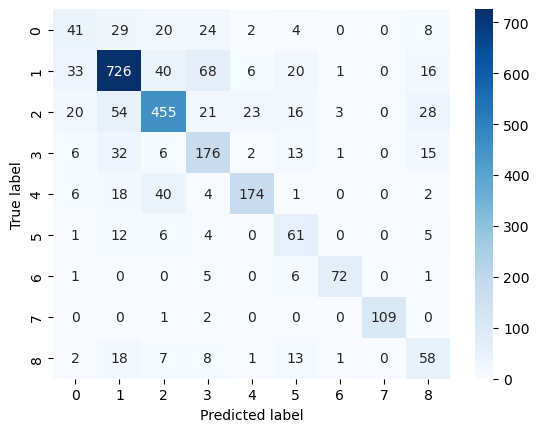

In [33]:
import time

# Train the final classifier on the entire training set using the best hyperparameters
final_mlp = MLPClassifier(**grid_search_mlp.best_params_)
start_time = time.time()
final_mlp.fit(X_train_all, y_train_all)
end_time = time.time()
training_time = end_time - start_time
print("Training time: ", training_time)

# Evaluate the final classifier on the test set
start_time = time.time()
y_pred = final_mlp.predict(X_evaluation)
end_time = time.time()
testing_time = end_time - start_time
print("Testing time: ", testing_time)

test_score = f1_score(y_evaluation, y_pred, average='macro')
print("Test score (macro f1): ", test_score)

print("Accuracy:", accuracy_score(y_evaluation, y_pred))
print("Precision:", precision_score(y_evaluation, y_pred, average='macro'))
print("Recall:", recall_score(y_evaluation, y_pred, average='macro'))
print("F1-score:", f1_score(y_evaluation, y_pred, average='macro'))
print("Confusion matrix:")

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_evaluation, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
